Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [77]:
import os
print(os.getcwd())

/workfile


In [78]:
!pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs'
output = 'CNN_assignment.zip'
gdown.download(url, output, quiet=False)


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


Downloading...
From (uriginal): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
From (redirected): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&confirm=t&uuid=d6ad0db5-7c1d-455f-82ba-caeed4ea02ae
To: /workfile/CNN_assignment.zip
100%|██████████| 824M/824M [00:24<00:00, 33.0MB/s] 


'CNN_assignment.zip'

In [79]:
# !unzip -o CNN_assignment.zip -d /workfile/content

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-01-09 04:22:58.551830: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 04:22:58.789722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

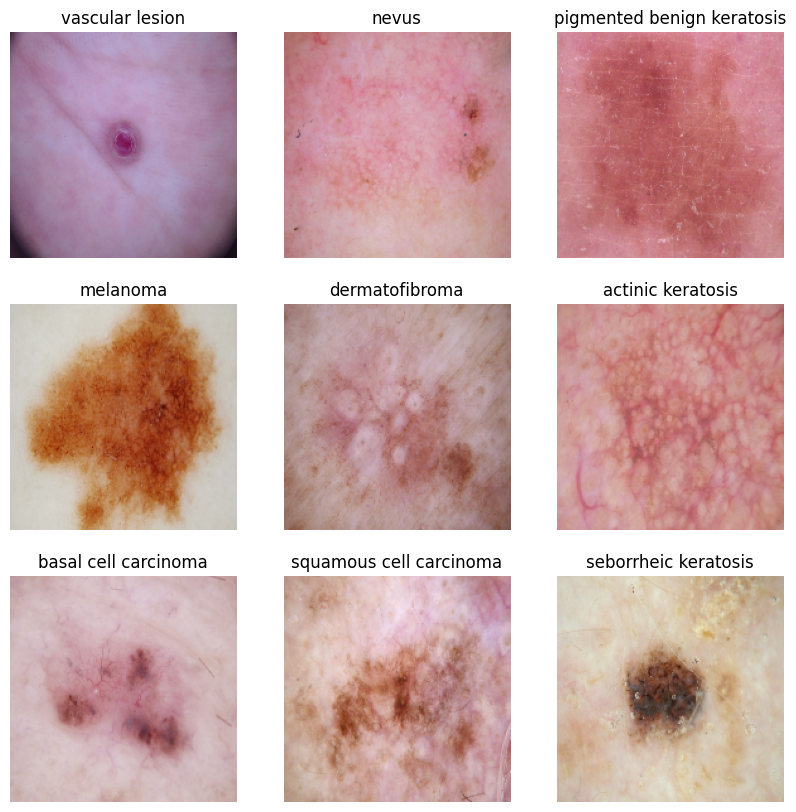

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
class_names = train_ds.class_names

# Initialize a dictionary to keep track of classes
seen_classes = {class_name: False for class_name in class_names}

# Plotting
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(len(labels)):
        class_name = class_names[labels[i]]
        if not seen_classes[class_name]:
            plt.subplot(3, 3, list(seen_classes.values()).count(True) + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")

            seen_classes[class_name] = True

        if all(seen_classes.values()):
            break
    if all(seen_classes.values()):
        break

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from tensorflow.keras import layers, models

# Model parameters
num_classes = len(class_names)
input_shape = (180, 180, 3)

# Build the model
model1 = models.Sequential([
    # Rescaling layer to normalize pixel values
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    # Convolutional layer 1
    layers.Conv2D(32, 3, activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),

    # Convolutional layer 2
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    # Convolutional layer 3
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    # Flattening the output for the dense layer
    layers.Flatten(),

    # Dense layer
    layers.Dense(32, activation='relu'),

    # Output layer with softmax activation for multi-class classification
    layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

### Train the model

In [14]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 10s 117ms/step - loss: 2.0674 - accuracy: 0.2249 - val_loss: 1.9714 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 6s 107ms/step - loss: 1.9672 - accuracy: 0.2723 - val_loss: 1.8970 - val_accuracy: 0.2707
Epoch 3/20
56/56 [==============================] - 6s 106ms/step - loss: 1.8437 - accuracy: 0.3281 - val_loss: 1.7782 - val_accuracy: 0.3624
Epoch 4/20
56/56 [==============================] - 6s 104ms/step - loss: 1.7341 - accuracy: 0.4046 - val_loss: 1.8727 - val_accuracy: 0.3289
Epoch 5/20
56/56 [==============================] - 6s 101ms/step - loss: 1.6099 - accuracy: 0.4542 - val_loss: 1.5573 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 6s 108ms/step - loss: 1.4676 - accuracy: 0.4810 - val_loss: 1.5927 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 6s 108ms/step - loss: 1.4453 - accuracy: 0.4883 - val_loss: 1.7007 - val_accuracy: 0.4206
Epoch 8/20
56/56

### Visualizing training results

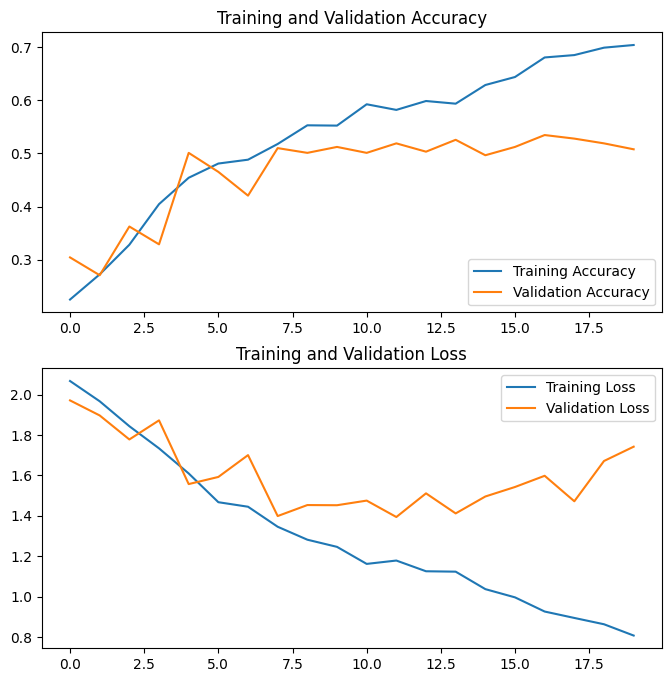

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here - Written 1

- The model demonstrated consistent improvement over 20 epochs, with training accuracy increasing from 22.49% to 70.42%, and validation accuracy reaching 50.7%. However, the increasing trend in validation loss suggests potential overfitting. It's advisable to investigate regularization techniques or adjust the model architecture for better generalization.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming data augmentation is needed
data_augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

(-0.5, 179.5, 179.5, -0.5)

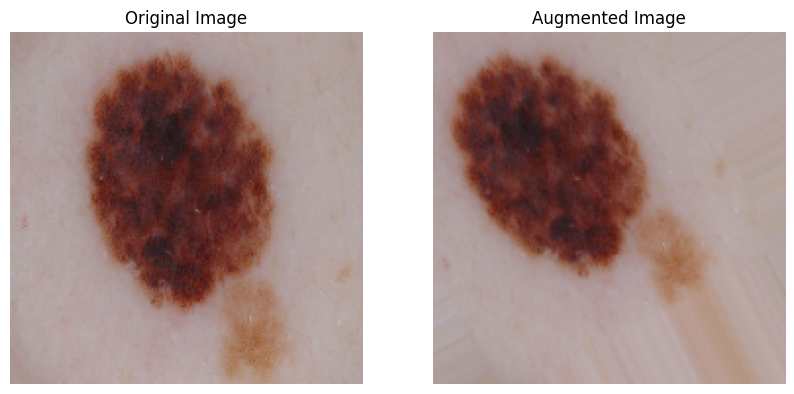

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for images, labels in train_ds.take(1):
    sample_image = images[0].numpy()
    sample_image_expanded = np.expand_dims(sample_image, axis=0)
    break

aug_iter = data_augmentation.flow(sample_image_expanded, batch_size=1)
augmented_image = next(aug_iter)[0]

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_image.astype('uint8'))
plt.axis("off")

# Augmented Image
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_image.astype('uint8'))
plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

from tensorflow.keras import models, layers

model2 = models.Sequential([
    # Rescaling layer to normalize pixel values
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    # Convolutional layer 1
    layers.Conv2D(128, 3, activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),  # Dropout layer added

    # Convolutional layer 2
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),  # Dropout layer added

    # Convolutional layer 3
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),  # Dropout layer added

    # Flattening the output for the dense layer
    layers.Flatten(),

    # Dense layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.25),  # Higher dropout rate before the final layer

    # Output layer with softmax activation for multi-class classification
    layers.Dense(num_classes, activation='softmax')
])


### Compiling the model

In [19]:
## Your code goes here
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 31s 535ms/step - loss: 2.1024 - accuracy: 0.1931 - val_loss: 2.0835 - val_accuracy: 0.1566
Epoch 2/20
56/56 [==============================] - 30s 543ms/step - loss: 2.0494 - accuracy: 0.1942 - val_loss: 2.0532 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 29s 527ms/step - loss: 2.0095 - accuracy: 0.2321 - val_loss: 2.0291 - val_accuracy: 0.2125
Epoch 4/20
56/56 [==============================] - 32s 568ms/step - loss: 2.0053 - accuracy: 0.2243 - val_loss: 1.9207 - val_accuracy: 0.3087
Epoch 5/20
56/56 [==============================] - 30s 545ms/step - loss: 1.9273 - accuracy: 0.2690 - val_loss: 1.8507 - val_accuracy: 0.3378
Epoch 6/20
56/56 [==============================] - 31s 560ms/step - loss: 1.8654 - accuracy: 0.3019 - val_loss: 1.7325 - val_accuracy: 0.3624
Epoch 7/20
56/56 [==============================] - 31s 550ms/step - loss: 1.8718 - accuracy: 0.3002 - val_loss: 1.8395 - val_accuracy: 0.3333

### Visualizing the results

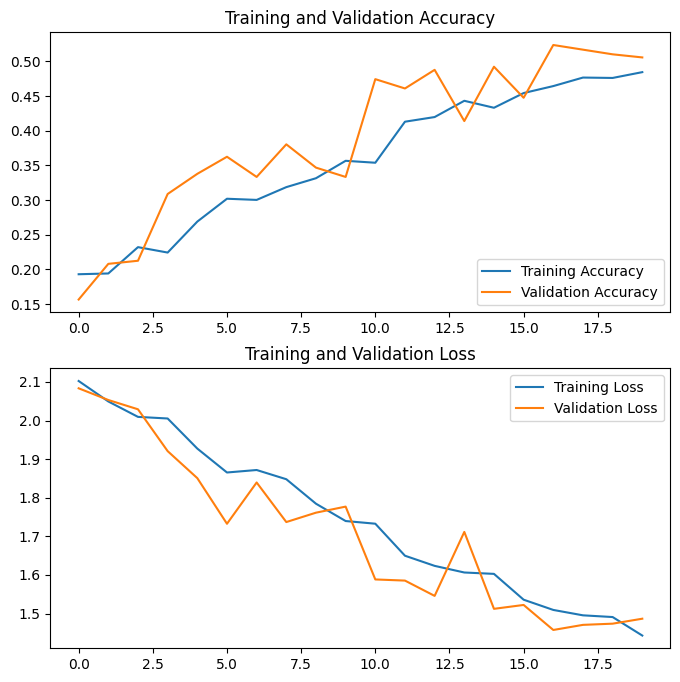

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run? 


#### Written 2

- The model2 shows a significant decrease in accuracy, dropping from 70.42% to 48.44%. However, the validation loss has improved, decreasing from 1.7424 to 1.4865. This indicates the model is generalizing better despite a loss in accuracy, suggesting a need for further model refinement to balance both aspects.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

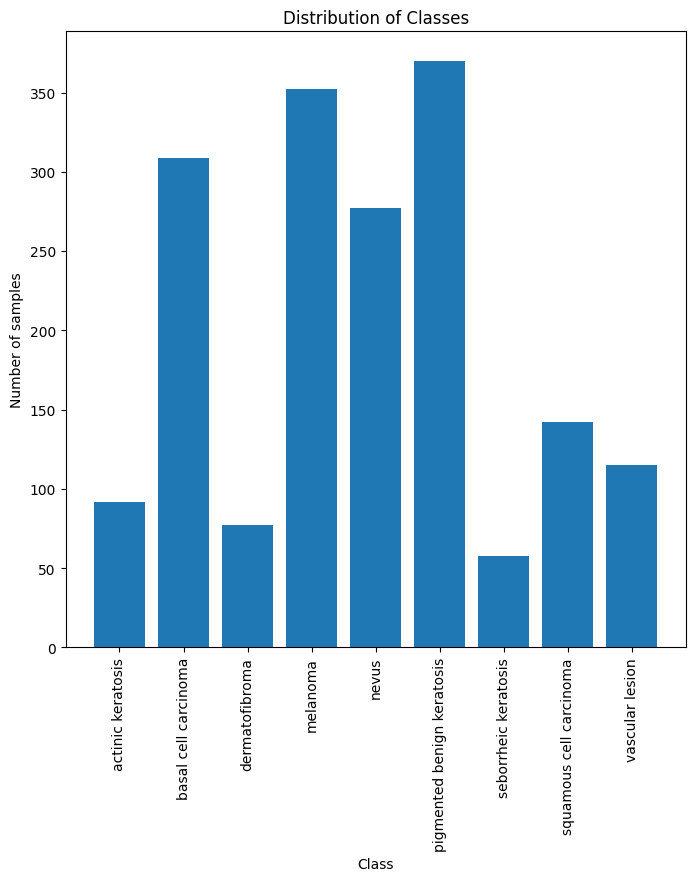

In [22]:
## Your code goes here.
class_counts = {}

for images, labels in train_ds:
    for label in labels.numpy():
        # Convert numerical label to class name
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Sort the classes if necessary
sorted_class_counts = dict(sorted(class_counts.items()))

# Plotting
plt.figure(figsize=(8, 8))
plt.bar(range(len(sorted_class_counts)), list(sorted_class_counts.values()), tick_label=list(sorted_class_counts.keys()))
plt.xticks(rotation=90)  # Rotate labels if there are many classes
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Distribution of Classes')
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


### Written 3

`dermatofibroma` has least sample.

`pigmented benign keratosis` has dominate the data.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
## Remove all jpg in output
for jpg_file in data_dir_train.glob('*/output/*.jpg'):
    jpg_file.unlink()

In [25]:
path_to_training_dataset= data_dir_train
import Augmentor

for i in class_names:
    class_path = path_to_training_dataset / i
    p = Augmentor.Pipeline(str(class_path))
    
     # Rotation
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Zooming and Random Cropping
    p.zoom_random(probability=0.7, percentage_area=0.9)

    p.random_distortion(probability=0.7, grid_width=2, grid_height=2, magnitude=4)
    
    p.sample(500)  # Adding 500 samples per class

Initialised with 114 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9778D02ED0>: 100%|██████████| 500/500 [00:02<00:00, 222.15 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F96E830A390>: 100%|██████████| 500/500 [00:02<00:00, 235.70 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F96E80A1210>: 100%|██████████| 500/500 [00:02<00:00, 182.81 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F96E947B190>: 100%|██████████| 500/500 [00:13<00:00, 38.19 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F96645EF6D0>: 100%|██████████| 500/500 [00:09<00:00, 51.33 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F96E0111150>: 100%|██████████| 500/500 [00:02<00:00, 171.99 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F96E93FA5D0>: 100%|██████████| 500/500 [00:05<00:00, 91.80 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9778D4B690>: 100%|██████████| 500/500 [00:02<00:00, 168.63 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /workfile/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F96E80223D0>: 100%|██████████| 500/500 [00:02<00:00, 205.19 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
import glob

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
# List of file paths to .jpg files
path_list_orig = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]

# Corresponding list of parent directory names for each .jpg file
lesion_list_orig = [os.path.basename(os.path.dirname(y)) for y in path_list_orig]

# Creating the dictionary
dataframe_dict_orig = dict(zip(path_list_orig, lesion_list_orig))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict_orig.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [32]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
# data_dir_train=  pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
num_classes = 9
input_shape = (180, 180, 3)
from tensorflow.keras import models, layers, regularizers, optimizers

## your code goes here
model3 = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3), 
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  

    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Removed one Conv2D layer to simplify the model
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Reduced number of neurons
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 128)       0         
 g2D)                                                 

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model3.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

# Set up early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,          
    restore_best_weights=True 
)

#### **Todo:**  Train your model

In [38]:
epochs = 50

## Your code goes here, use 50 epochs.
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_callback]
)

Epoch 1/50
169/169 [==============================] - 133s 781ms/step - loss: 2.0456 - accuracy: 0.2858 - val_loss: 1.8632 - val_accuracy: 0.3504
Epoch 2/50
169/169 [==============================] - 135s 795ms/step - loss: 1.7562 - accuracy: 0.3780 - val_loss: 3.7490 - val_accuracy: 0.3007
Epoch 3/50
169/169 [==============================] - 132s 777ms/step - loss: 1.5990 - accuracy: 0.4154 - val_loss: 5.0735 - val_accuracy: 0.1730
Epoch 4/50
169/169 [==============================] - 131s 772ms/step - loss: 1.4957 - accuracy: 0.4451 - val_loss: 1.8416 - val_accuracy: 0.3749
Epoch 5/50
169/169 [==============================] - 133s 787ms/step - loss: 1.3884 - accuracy: 0.4796 - val_loss: 2.1955 - val_accuracy: 0.3237
Epoch 6/50
169/169 [==============================] - 136s 801ms/step - loss: 1.3579 - accuracy: 0.4941 - val_loss: 2.4244 - val_accuracy: 0.3014
Epoch 7/50
169/169 [==============================] - 134s 792ms/step - loss: 1.3054 - accuracy: 0.5130 - val_loss: 1.3200 -

#### **Todo:**  Visualize the model results

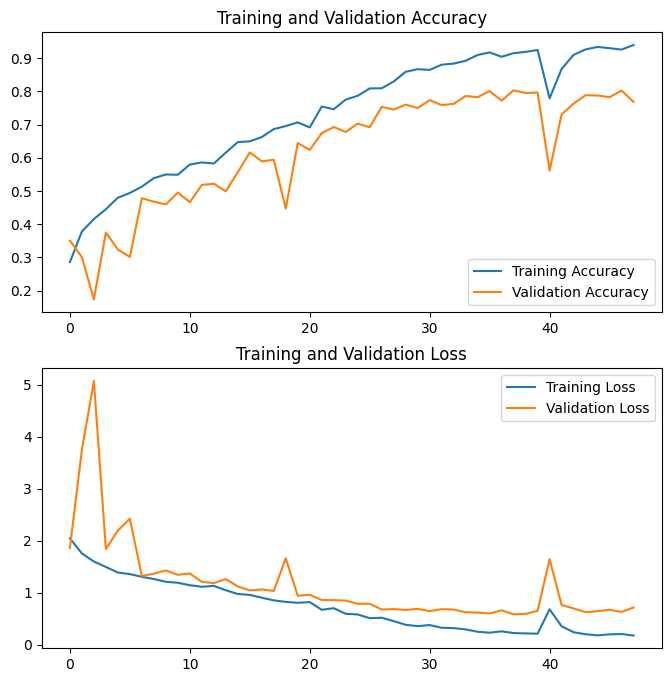

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = len(acc)

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [41]:
# Evaluate the model on the test dataset
loss, accuracy = model2.evaluate(test_dataset)

print(f"Test accuracy: {accuracy*100:.2f}%")

4/4 [==============================] - 1s 331ms/step - loss: 2.7352 - accuracy: 0.3475
Test accuracy: 34.75%


In [42]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    shuffle=False,
    batch_size=32,
    image_size=(180, 180)
)

# Evaluate the model on the test dataset
loss, accuracy = model3.evaluate(test_dataset)

print(f"Test accuracy: {accuracy*100:.2f}%")

Found 118 files belonging to 9 classes.
4/4 [==============================] - 1s 244ms/step - loss: 3.0955 - accuracy: 0.4322
Test accuracy: 43.22%


#### Written 4

- Model 3 shows significant improvement over Model 2, with a higher test accuracy (43.22% vs 34.75%) and better performance metrics in the final epoch (accuracy of 93.97% vs 48.44%, and lower validation loss). These improvements indicate effective mitigation of overfitting issues, likely aided by augmentor rebalancing.